# Cell cycle label transfer

In this notebook we show how to use transmorph and leverage optimal transport to perform label transfer between cells.

## Data loading

In [44]:
from transmorph.datasets import load_cell_cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

datasets = load_cell_cycle()

databank_api > Loading bank cell_cycle.
databank_api > Bank cell_cycle successfully loaded.


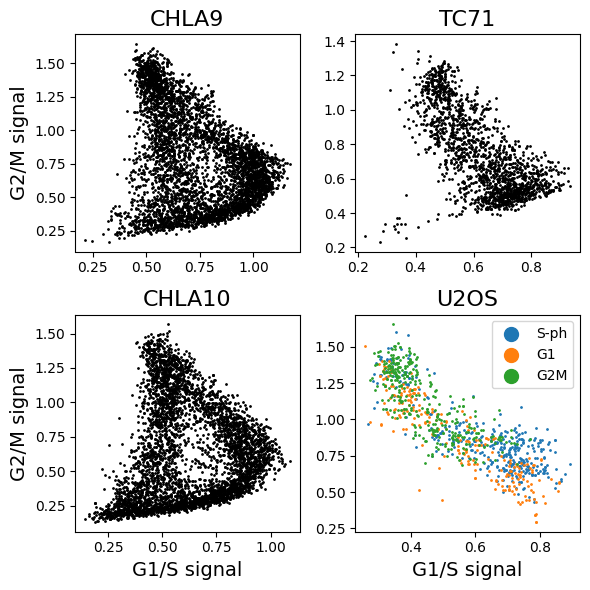

In [45]:
figure = plt.figure(figsize=(6,6))
for i, (name, adata) in enumerate(datasets.items()):
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    plt.subplot(2, 2, i + 1)
    if name == 'U2OS':
        annotations = adata.obs['Cell cycle phase']
        for cc_annot in set(annotations):
            sel = annotations == cc_annot
            plt.scatter(adata.obs['G1/S'][sel], adata.obs['G2/M'][sel], s=1, label=cc_annot)
        plt.legend(markerscale=10)
    else:
        plt.scatter(adata.obs['G1/S'], adata.obs['G2/M'], s=1, c='k')
    if i in (2, 3):
        plt.xlabel('G1/S signal', fontsize=14)
    if i in (0, 2):
        plt.ylabel('G2/M signal', fontsize=14)
    plt.title(name, fontsize=16)
plt.tight_layout()

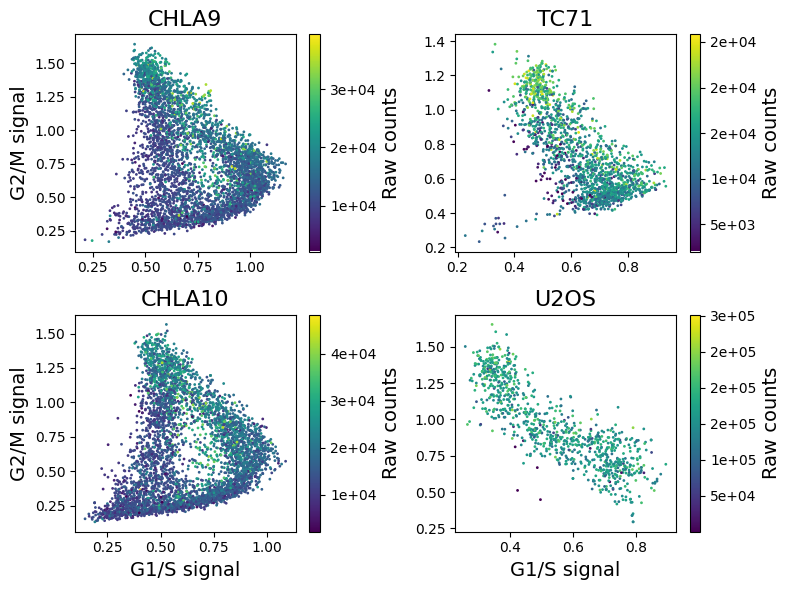

In [69]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    return '{:.0e}'.format(x)

figure = plt.figure(figsize=(8,6))
for i, (name, adata) in enumerate(datasets.items()):
    obs = None
    mode = 'dataset'
    if name =figure = plt.figure(figsize=(6,6))
for i, (name, adata) in enumerate(datasets.items()):
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    plt.subplot(2, 2, i + 1)
    if name == 'U2OS':
        annotations = adata.obs['Cell cycle phase']
        for cc_annot in set(annotations):
            sel = annotations == cc_annot
            plt.scatter(adata.obs['G1/S'][sel], adata.obs['G2/M'][sel], s=1, label=cc_annot)
        plt.legend(markerscale=10)
    else:
        plt.scatter(adata.obs['G1/S'], adata.obs['G2/M'], s=1, c='k')
    if i in (2, 3):
        plt.xlabel('G1/S signal', fontsize=14)
    if i in (0, 2):
        plt.ylabel('G2/M signal', fontsize=14)
    plt.title(name, fontsize=16)
plt.tight_layout()= 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    plt.subplot(2, 2, i + 1)        
    plt.scatter(adata.obs['G1/S'], adata.obs['G2/M'], 
                s=1, c=adata.layers['raw_counts'].toarray().sum(axis=1))
    if i in (2, 3):
        plt.xlabel('G1/S signal', fontsize=14)
    if i in (0, 2):
        plt.ylabel('G2/M signal', fontsize=14)
    plt.title(name, fontsize=16)
    cbar = plt.colorbar(format=ticker.FuncFormatter(fmt))
    cbar.ax.set_ylabel("Raw counts", fontsize=14)
    cbar.ax.set_ymargin(15)
plt.tight_layout()

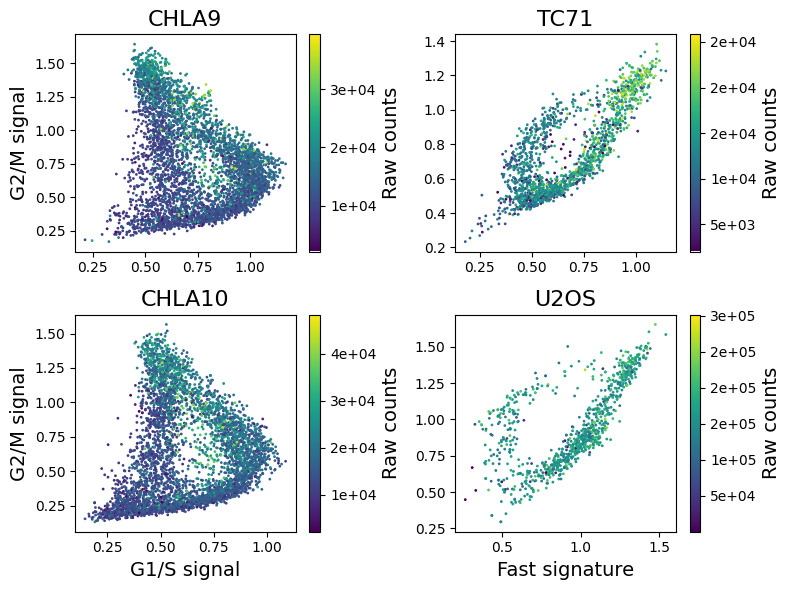

In [67]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    return '{:.0e}'.format(x)

figure = plt.figure(figsize=(8,6))
for i, (name, adata) in enumerate(datasets.items()):
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    plt.subplot(2, 2, i + 1)
    if name in ('U2OS', 'TC71'):
        xs = adata.obs['Fast']
    else:
        xs = adata.obs['G1/S']
    plt.scatter(xs, adata.obs['G2/M'], 
                s=1, c=adata.layers['raw_counts'].toarray().sum(axis=1))
    if i == 2:
        plt.xlabel('G1/S signal', fontsize=14)
    if i == 3:
        plt.xlabel('Fast signature', fontsize=14)
    if i in (0, 2):
        plt.ylabel('G2/M signal', fontsize=14)
    plt.title(name, fontsize=16)
    cbar = plt.colorbar(format=ticker.FuncFormatter(fmt))
    cbar.ax.set_ylabel("Raw counts", fontsize=14)
    cbar.ax.set_ymargin(15)
plt.tight_layout()

## With optimal transport

In [46]:
# Loading and fitting the model
from transmorph.models import TransportCorrection

# use_feature_space=True returns a result in  the original genes space
model = TransportCorrection(
    solver="unbalanced",
    use_feature_space=True,
    entropy_epsilon=2e-2, # These two parameters should be tweaked
    unbalanced_reg=5.0
)
model.transform(datasets, reference=datasets["CHLA10"], output_representation="otcorrection")

MNN_CORRECTION > Transmorph model is initializing.
MNN_CORRECTION > Ready to start the integration of 4 datasets, 11552 total samples.
MNN_CORRECTION > Running layer LAYER_INPUT#12.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#13.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#14.
MNN_CORRECTION > Running layer LAYER_MATCHING#15.
LAYER_MATCHING#15 > Calling matching MATCHING_OT.
MNN_CORRECTION > Running layer LAYER_MERGING#16.
LAYER_MERGING#16 > Running merging MERGING_BARYCENTER...
MNN_CORRECTION > Running layer LAYER_OUTPUT#17.
MNN_CORRECTION > Terminated. Total embedding shape: (11552, 742)
MNN_CORRECTION > Results have been written in AnnData.obsm['otcorrection'].


In [47]:
# TC71 and U2OS are "fast" cell cycle datasets.
# Using these genes for G1/S signature yields clearer
# visualizations.
fast_cell_cycle_g1s = [
    'CDK1', 'UBE2C', 'TOP2A', 'TMPO', 'HJURP', 'RRM1',
    'RAD51AP1', 'RRM2', 'CDC45', 'BLM', 'BRIP1', 'E2F8', 'HIST2H2AC'
]

embedding_genes = model.embedding_features
g1s_indices = datasets['CHLA10'][:, embedding_genes].var['G1/S gene'].to_numpy()
g2m_indices = datasets['CHLA10'][:, embedding_genes].var['G2/M gene'].to_numpy()

for name, adata in datasets.items():
    cc_coordinates = np.zeros((adata.n_obs, 2))
    cc_coordinates[:, 0] = adata.obsm['otcorrection'][:, g1s_indices].mean(axis=1)
    cc_coordinates[:, 1] = adata.obsm['otcorrection'][:, g2m_indices].mean(axis=1)
    # Filtering out a few outliers
    adata.obsm['corrected_cell_cycle_ot'] = cc_coordinates

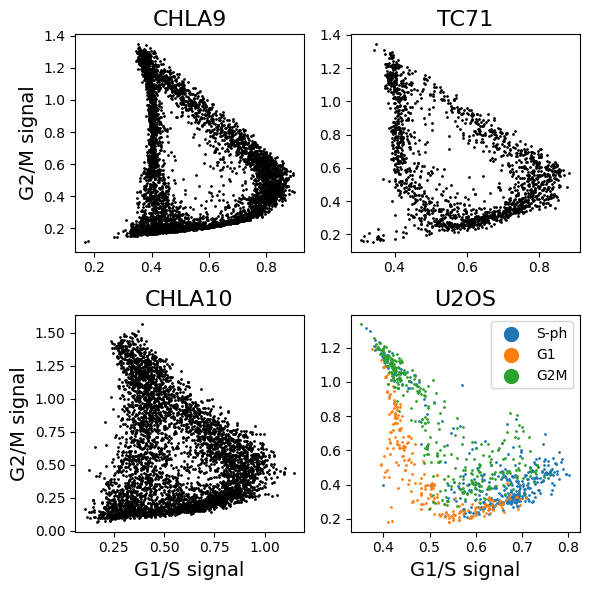

In [48]:
figure = plt.figure(figsize=(6,6))
for i, (name, adata) in enumerate(datasets.items()):
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    plt.subplot(2, 2, i + 1)
    if name == 'U2OS':
        annotations = adata.obs['Cell cycle phase']
        for cc_annot in set(annotations):
            if cc_annot == 'NotAssigned':
                continue
            plt.scatter(*adata.obsm['corrected_cell_cycle_ot'][annotations == cc_annot].T, 
                        s=1, label=cc_annot)
        plt.legend(markerscale=10)
    else:
        plt.scatter(*adata.obsm['corrected_cell_cycle_ot'].T, s=1, c='k')
    if i in (2, 3):
        plt.xlabel('G1/S signal', fontsize=14)
    if i in (0, 2):
        plt.ylabel('G2/M signal', fontsize=14)
    plt.title(name, fontsize=16)
plt.tight_layout()

In [49]:
from transmorph.utils.infer import label_transfer_knn
from warnings import simplefilter
simplefilter('ignore')

label_transfer_knn(datasets, datasets['U2OS'], 'Cell cycle phase', 
                   use_rep='corrected_cell_cycle_ot')

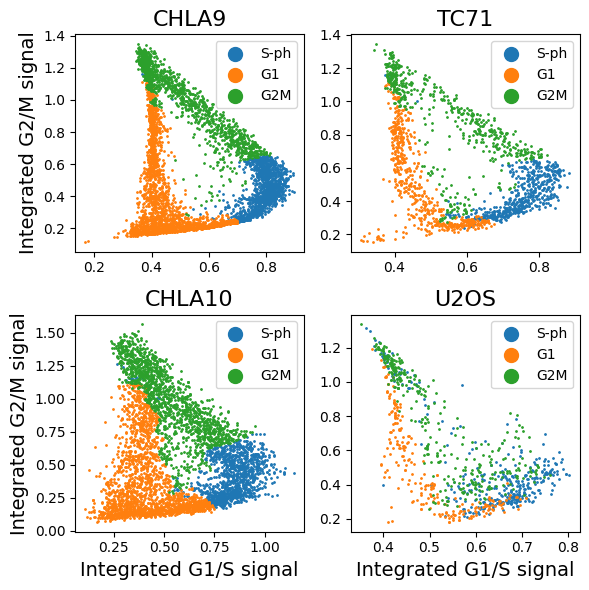

In [50]:
figure = plt.figure(figsize=(6,6))
for i, (name, adata) in enumerate(datasets.items()):
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    plt.subplot(2, 2, i + 1)
    annotations = adata.obs['Cell cycle phase']
    for cc_annot in set(annotations):
        if cc_annot == 'NotAssigned':
            continue
        plt.scatter(*adata.obsm['corrected_cell_cycle_ot'][annotations == cc_annot].T, 
                    s=1, label=cc_annot)
    plt.legend(markerscale=10)
    if i in (2, 3):
        plt.xlabel('Integrated G1/S signal', fontsize=14)
    if i in (0, 2):
        plt.ylabel('Integrated G2/M signal', fontsize=14)
    plt.title(name, fontsize=16)
plt.tight_layout()

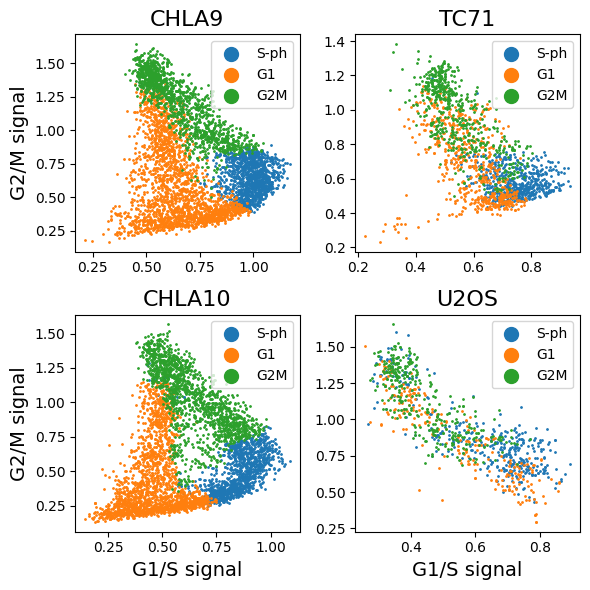

In [51]:
figure = plt.figure(figsize=(6,6))
for i, (name, adata) in enumerate(datasets.items()):
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    plt.subplot(2, 2, i + 1)
    annotations = adata.obs['Cell cycle phase']
    for cc_annot in set(annotations):
        sel = annotations == cc_annot
        plt.scatter(adata.obs['G1/S'][sel], adata.obs['G2/M'][sel], s=1, label=cc_annot)
    plt.legend(markerscale=10)
    if i in (2, 3):
        plt.xlabel('G1/S signal', fontsize=14)
    if i in (0, 2):
        plt.ylabel('G2/M signal', fontsize=14)
    plt.title(name, fontsize=16)
plt.tight_layout()

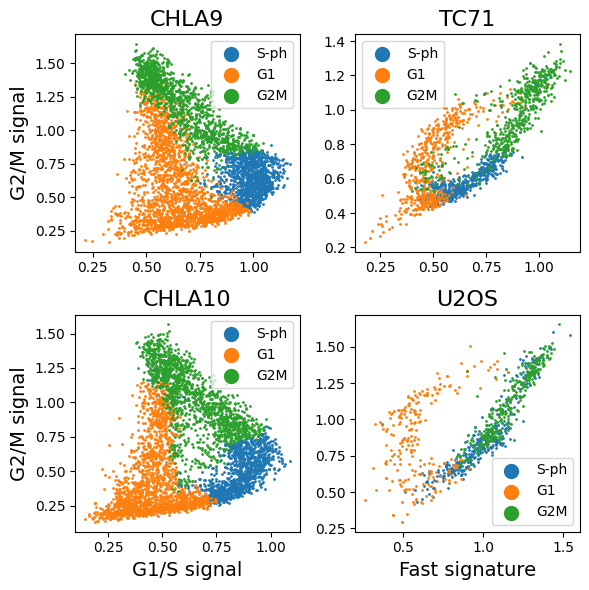

In [52]:
figure = plt.figure(figsize=(6,6))
for i, (name, adata) in enumerate(datasets.items()):
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    plt.subplot(2, 2, i + 1)
    annotations = adata.obs['Cell cycle phase']
    for cc_annot in set(annotations):
        sel = annotations == cc_annot
        if name in ('U2OS', 'TC71'):
            plt.scatter(adata.obs['Fast'][sel], adata.obs['G2/M'][sel], s=1, label=cc_annot)
        else:
            plt.scatter(adata.obs['G1/S'][sel], adata.obs['G2/M'][sel], s=1, label=cc_annot)
    plt.legend(markerscale=10)
    if i == 2:
        plt.xlabel('G1/S signal', fontsize=14)
    if i == 3:
        plt.xlabel('Fast signature', fontsize=14)
    if i in (0, 2):
        plt.ylabel('G2/M signal', fontsize=14)
    plt.title(name, fontsize=16)
plt.tight_layout()

## With MNN

In [20]:
# Loading and fitting the model
from transmorph.models import MNNCorrection

# use_feature_space=True returns a result in  the original genes space
model = MNNCorrection()
model.transform(datasets, reference=datasets["CHLA10"], output_representation="mnncorrection")

MNN_CORRECTION > Transmorph model is initializing.
MNN_CORRECTION > Ready to start the integration of 4 datasets, 11552 total samples.
MNN_CORRECTION > Running layer LAYER_INPUT#6.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#7.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#8.
MNN_CORRECTION > Running layer LAYER_MATCHING#9.
LAYER_MATCHING#9 > Calling matching MATCHING_MNN.
MNN_CORRECTION > Running layer LAYER_MERGING#10.
LAYER_MERGING#10 > Running merging MERGING_LINEAR_CORRECTION...
MNN_CORRECTION > Running layer LAYER_OUTPUT#11.
MNN_CORRECTION > Terminated. Total embedding shape: (11552, 742)
MNN_CORRECTION > Results have been written in AnnData.obsm['mnncorrection'].


In [21]:
# TC71 and U2OS are "fast" cell cycle datasets.
# Using these genes for G1/S signature yields clearer
# visualizations.
fast_cell_cycle_g1s = [
    'CDK1', 'UBE2C', 'TOP2A', 'TMPO', 'HJURP', 'RRM1',
    'RAD51AP1', 'RRM2', 'CDC45', 'BLM', 'BRIP1', 'E2F8', 'HIST2H2AC'
]

embedding_genes = model.embedding_features
g1s_indices = datasets['CHLA10'][:, embedding_genes].var['G1/S gene'].to_numpy()
g2m_indices = datasets['CHLA10'][:, embedding_genes].var['G2/M gene'].to_numpy()

for name, adata in datasets.items():
    cc_coordinates = np.zeros((adata.n_obs, 2))
    cc_coordinates[:, 0] = adata.obsm['mnncorrection'][:, g1s_indices].mean(axis=1)
    cc_coordinates[:, 1] = adata.obsm['mnncorrection'][:, g2m_indices].mean(axis=1)
    adata.obsm['corrected_cell_cycle_mnn'] = cc_coordinates

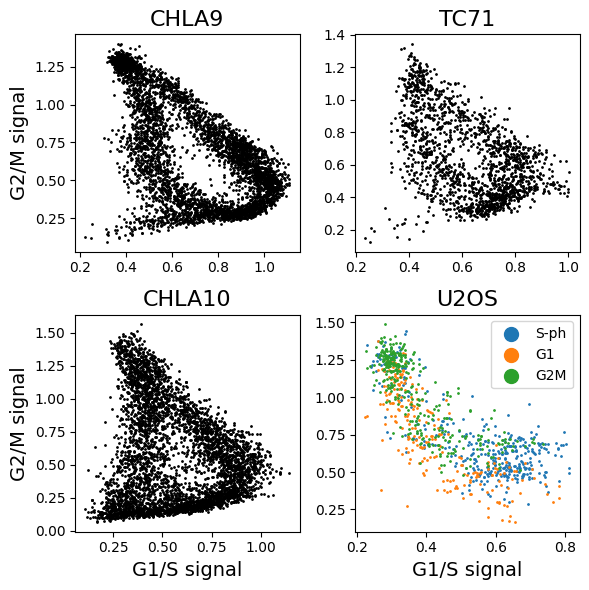

In [22]:
figure = plt.figure(figsize=(6,6))
for i, (name, adata) in enumerate(datasets.items()):
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    plt.subplot(2, 2, i + 1)
    if name == 'U2OS':
        annotations = adata.obs['Cell cycle phase']
        for cc_annot in set(annotations):
            if cc_annot == 'NotAssigned':
                continue
            plt.scatter(*adata.obsm['corrected_cell_cycle_mnn'][annotations == cc_annot].T, 
                        s=1, label=cc_annot)
        plt.legend(markerscale=10)
    else:
        plt.scatter(*adata.obsm['corrected_cell_cycle_mnn'].T, s=1, c='k')
    if i in (2, 3):
        plt.xlabel('G1/S signal', fontsize=14)
    if i in (0, 2):
        plt.ylabel('G2/M signal', fontsize=14)
    plt.title(name, fontsize=16)
plt.tight_layout()

In [23]:
from transmorph.utils.infer import label_transfer_knn
from warnings import simplefilter
simplefilter('ignore')

label_transfer_knn(datasets, datasets['U2OS'], 'Cell cycle phase', 
                   use_rep='corrected_cell_cycle_mnn')

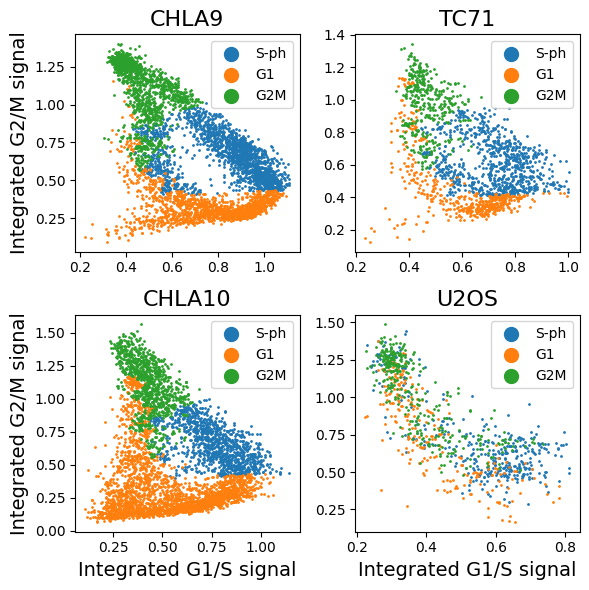

In [24]:
figure = plt.figure(figsize=(6,6))
for i, (name, adata) in enumerate(datasets.items()):
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    plt.subplot(2, 2, i + 1)
    annotations = adata.obs['Cell cycle phase']
    for cc_annot in set(annotations):
        if cc_annot == 'NotAssigned':
            continue
        plt.scatter(*adata.obsm['corrected_cell_cycle_mnn'][annotations == cc_annot].T, 
                    s=1, label=cc_annot)
    plt.legend(markerscale=10)
    if i in (2, 3):
        plt.xlabel('Integrated G1/S signal', fontsize=14)
    if i in (0, 2):
        plt.ylabel('Integrated G2/M signal', fontsize=14)
    plt.title(name, fontsize=16)
plt.tight_layout()

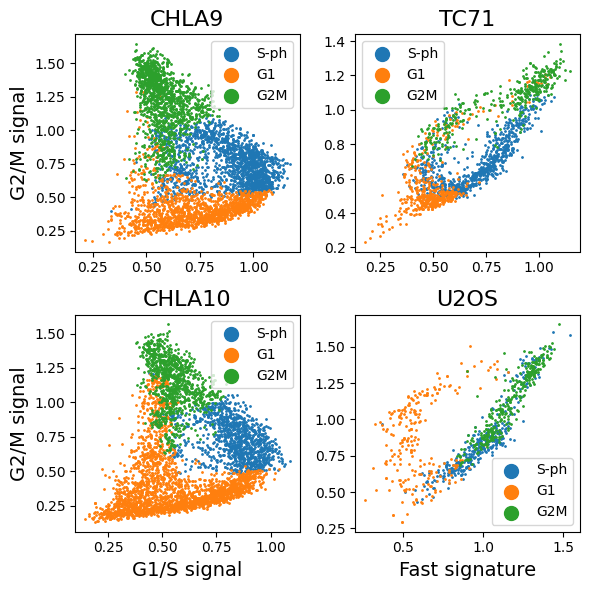

In [25]:
figure = plt.figure(figsize=(6,6))
for i, (name, adata) in enumerate(datasets.items()):
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    plt.subplot(2, 2, i + 1)
    annotations = adata.obs['Cell cycle phase']
    for cc_annot in set(annotations):
        sel = annotations == cc_annot
        if name in ('U2OS', 'TC71'):
            plt.scatter(adata.obs['Fast'][sel], adata.obs['G2/M'][sel], s=1, label=cc_annot)
        else:
            plt.scatter(adata.obs['G1/S'][sel], adata.obs['G2/M'][sel], s=1, label=cc_annot)
    plt.legend(markerscale=10)
    if i == 2:
        plt.xlabel('G1/S signal', fontsize=14)
    if i == 3:
        plt.xlabel('Fast signature', fontsize=14)
    if i in (0, 2):
        plt.ylabel('G2/M signal', fontsize=14)
    plt.title(name, fontsize=16)
plt.tight_layout()

## Differential gene expression between clusters

In [75]:
import scanpy as sc
import math

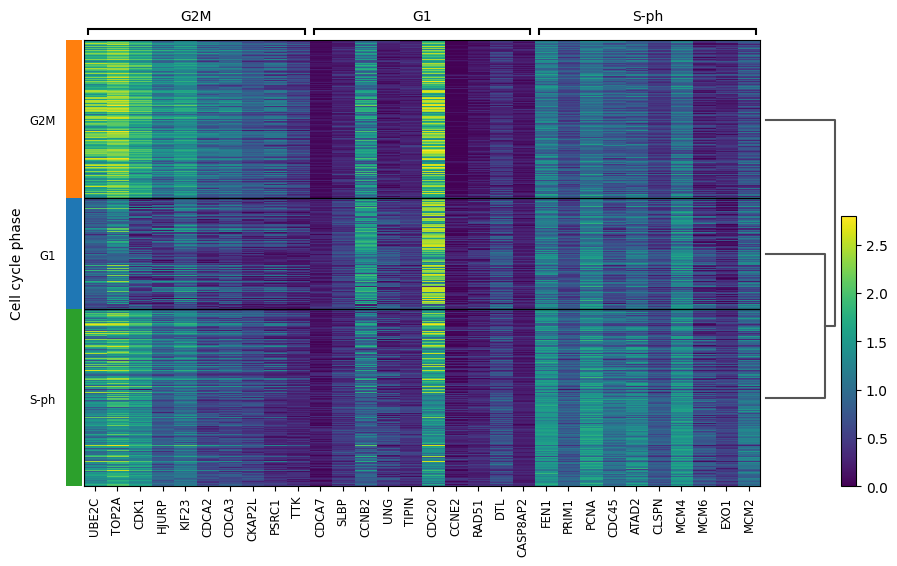

In [83]:
name = 'U2OS'
adata = datasets[name]
adata_cc = adata[:, np.logical_or(adata.var['G1/S gene'], adata.var['G2/M gene'])].copy()
adata_cc.uns['log1p']['base'] = math.e
sc.tl.rank_genes_groups(adata_cc, 'Cell cycle phase', method='wilcoxon', key_added="wilcoxon")
sc.pl.rank_genes_groups_heatmap(adata_cc, n_genes=10, key="wilcoxon", groupby="Cell cycle phase", 
                                show_gene_labels=True)

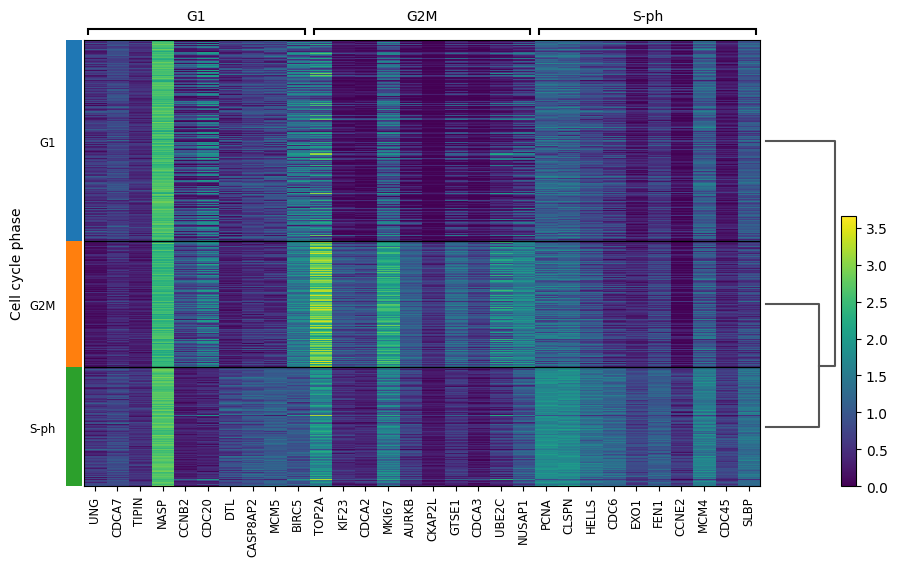

In [80]:
name = 'CHLA9'
adata = datasets[name]
adata_cc = adata[:, np.logical_or(adata.var['G1/S gene'], adata.var['G2/M gene'])].copy()
adata_cc.uns['log1p']['base'] = math.e
sc.tl.rank_genes_groups(adata_cc, 'Cell cycle phase', method='wilcoxon', key_added="wilcoxon")
sc.pl.rank_genes_groups_heatmap(adata_cc, n_genes=10, key="wilcoxon", groupby="Cell cycle phase", 
                                show_gene_labels=True)

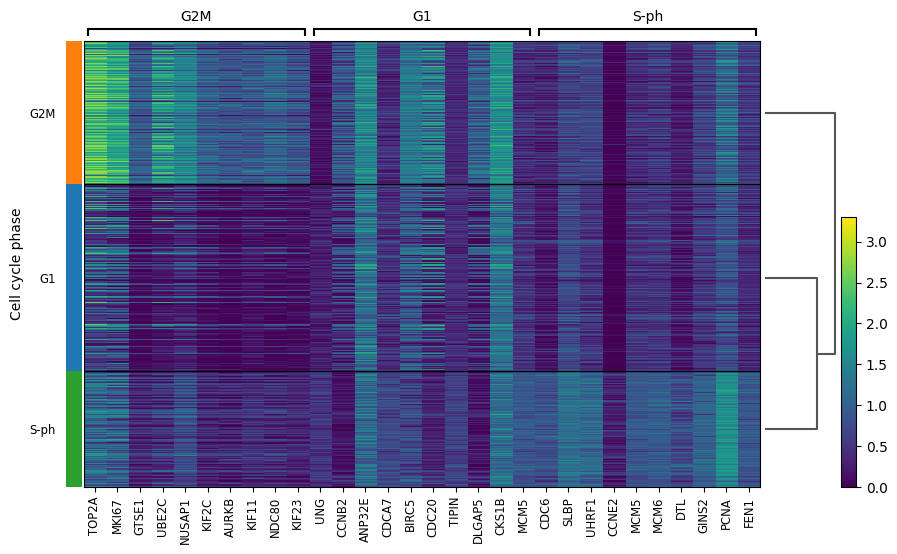

In [81]:
name = 'CHLA10'
adata = datasets[name]
adata_cc = adata[:, np.logical_or(adata.var['G1/S gene'], adata.var['G2/M gene'])].copy()
adata_cc.uns['log1p']['base'] = math.e
sc.tl.rank_genes_groups(adata_cc, 'Cell cycle phase', method='wilcoxon', key_added="wilcoxon")
sc.pl.rank_genes_groups_heatmap(adata_cc, n_genes=10, key="wilcoxon", groupby="Cell cycle phase", 
                                show_gene_labels=True)

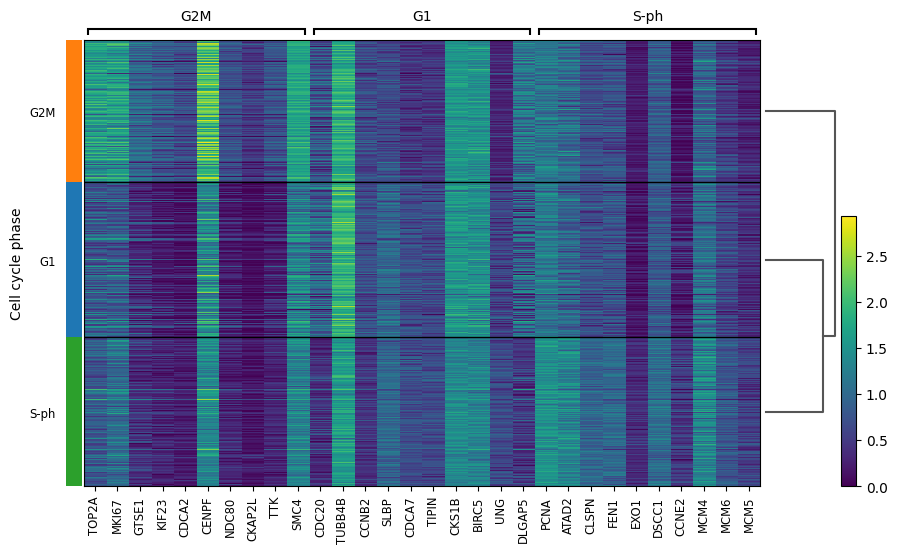

In [82]:
name = 'TC71'
adata = datasets[name]
adata_cc = adata[:, np.logical_or(adata.var['G1/S gene'], adata.var['G2/M gene'])].copy()
adata_cc.uns['log1p']['base'] = math.e
sc.tl.rank_genes_groups(adata_cc, 'Cell cycle phase', method='wilcoxon', key_added="wilcoxon")
sc.pl.rank_genes_groups_heatmap(adata_cc, n_genes=10, key="wilcoxon", groupby="Cell cycle phase", 
                                show_gene_labels=True)